<h3>Logistic Regression | Kaggle Data Set for Credit Card Fraud</h3>

Kaggle Credit Card Fraud Data Set - https://www.kaggle.com/mlg-ulb/creditcardfraud - 

In [1]:
# import libraries
import sys, os, time, csv, random
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize
%matplotlib inline
import matplotlib.pyplot as plt
# --------------------------------------------------------------
import importlib
from ipython_debug import *
from mybag import *
bag = MyBunch()

<h2>Explanation of terms:</h2>
<pre>TPR = True-Positive Rate  = sensitivity, recall, or probability of detection.
FPR = False-Positive Rate = fall-out, probability of false alarm.
------------------------------------------
ROC curve (Receiver Operating Characteristic curve) = TPR vs FPR
------------------------------------------
Precision P = (1 - false alarms)
       = fraction of relevant instances among the retrieved ones
Recall (sensitivity)
       = (relevant instances retrieved) / (total number of relevant instances)
------------------------------------------
F1 score = 2/(1/TPR + 1/P) - this is called 'harmonic average'
------------------------------------------
Confusion matrix:
    True  Negative    False Positive
    False Negative     True Positive
</pre>

In [2]:
def load_csv_data(bag):
    """
    # read CSV data from file into bag.df
    # starts populating bag.data_cols
    # optionally adds strong_predictor column
    """
    fname_in  = "data/creditcard.csv"
    print("reading file %s into a pandas DataFrame" % fname_in)
    df = pd.read_csv(fname_in, sep=",", dtype='object')
    df_len = len(df)
    mycols = df.columns
    df_col_len = len(mycols)
    print("read %d rows and %d columns" % (df_len, df_col_len))
    print("change column names by replacing ' ' by '_'")
    mycols = [colname.replace(" ","_") for colname in mycols]
    df.columns = mycols
    # -------------------------------------
    print("replace all nulls by empty strings")
    df.fillna("",inplace=True)
    df["Class"] = pd.to_numeric(df["Class"], errors='coerce')
    data_cols = mycols[:-1]  # last column is "Class" label
    
    # -------------------------------------
    if test_avail(bag, "strong_predictor_flag") and (bag.strong_predictor_flag == True):
        ampl = bag.strong_predictor_size
        nois = bag.strong_predictor_noise
        print("ATTENTION - invalidating data by adding strong predictor")
        df["strong_predictor"] = 0.4 + ampl*df["Class"] + nois*random.random()
        data_cols.append("strong_predictor")

    # -------------------------------------
    print("convert data columns to numeric")
    for colname in data_cols:
        df[colname]   = pd.to_numeric(df[colname], errors='coerce')

    df["Class"] = pd.to_numeric(df["Class"], errors='coerce')

    # -------------------------------------
    bag.df_orig = df
    bag.data_cols = data_cols

In [3]:
bag = MyBunch()
bag.strong_predictor_flag  = False  # option to add a column which is a strong predictor
bag.strong_predictor_size  = 0.2
bag.strong_predictor_noise = 0.2
bag.train_share = 0.7

load_csv_data(bag) # bag.df_orig, bag.data_cols
# pd.set_option('precision', 3)
# bag.df_orig.head(5).T # to view the data
# dfcols = list(bag.df_orig.columns)
# dfcols = dfcols[:-1]
# print(dfcols)
# bag.df_orig = bag.df_orig[dfcols].copy()
bag.df_orig.head(5).T # to view the data

reading file data/creditcard.csv into a pandas DataFrame
read 284807 rows and 31 columns
change column names by replacing ' ' by '_'
replace all nulls by empty strings
convert data columns to numeric


,0,1,2,3,4
Time,0.000000,0.000000,1.000000,1.000000,2.000000
V1,-1.359807,1.191857,-1.358354,-0.966272,-1.158233
V2,-0.072781,0.266151,-1.340163,-0.185226,0.877737
V3,2.536347,0.166480,1.773209,1.792993,1.548718
V4,1.378155,0.448154,0.379780,-0.863291,0.403034
V5,-0.338321,0.060018,-0.503198,-0.010309,-0.407193
V6,0.462388,-0.082361,1.800499,1.247203,0.095921
V7,0.239599,-0.078803,0.791461,0.237609,0.592941
V8,0.098698,0.085102,0.247676,0.377436,-0.270533
V9,0.363787,-0.255425,-1.514654,-1.387024,0.817739


In [4]:
bag.df_orig["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
def split_into_training_and_test(bag):
    """
    # splits data into two dataframes: df & df_t
    """
    # -------------------------------------
    print("Randomly select ~70% of data in both classes (majority and minority) for training.")
    print("The rest will be for testing.")
    df = bag.df_orig.copy()
    train_share = bag.train_share
    mycols = list(df.columns)
    mask = df["Class"] > 0.5
    dfs = df[mask].copy()
    dfo = df[~mask].copy()

    len_dfs = len(dfs)
    len_dfo = len(dfo)
    ns = int(train_share*len_dfs)
    no = int(train_share*len_dfo)

    # dfs - add randomly shuffled column "xx", sort by it, then remove it
    xx = [ii for ii in range(len_dfs)]
    random.shuffle(xx) # shuffle in place
    dfs['xx'] = xx
    dfs = dfs.sort_values(by=['xx'], axis=0, ascending=True, inplace=False)
    if 'xx' in dfs.columns:
        del dfs['xx']

    dfs = dfs[mycols]
    dfs.index = range(len(dfs))
    dfs_t = dfs[ns+1:].copy()
    dfs   = dfs[:ns]

    # dfo - add randomly shuffled column "xx", sort by it, then remove it
    xx = [ii for ii in range(len_dfo)]
    random.shuffle(xx) # shuffle in place
    dfo['xx'] = xx
    dfo = dfo.sort_values(by=['xx'], axis=0, ascending=True, inplace=False)
    if 'xx' in dfo.columns:
        del dfo['xx']

    dfo = dfo[mycols]
    dfo.index = range(len(dfo))
    dfo_t = dfo[no+1:].copy()
    dfo   = dfo[:no]

    bag.df   = pd.concat( [dfs   , dfo  ], ignore_index=True)   # training data
    bag.df_t = pd.concat( [dfs_t , dfo_t], ignore_index=True)   # testing data

In [6]:
def form_data_and_target_arrays(bag):
    """
    # populates bag.target, bag.target_t, bag.data, bag.data_t
    """
    bag.target   = bag.df["Class"].values
    bag.target_t = bag.df_t["Class"].values

    print("make two-dim array from df[data_col]")
    bag.data   = bag.df[bag.data_cols].values
    bag.data_t = bag.df_t[bag.data_cols].values
    print("data.shape   =", bag.data.shape)
    print("target.shape =", bag.target.shape)

In [7]:
split_into_training_and_test(bag) # bag.df, bag.df_t
form_data_and_target_arrays(bag)  # bag.target, bag.target_t, bag.data, bag.data_t

Randomly select ~70% of data in both classes (majority and minority) for training.
The rest will be for testing.
make two-dim array from df[data_col]
data.shape   = (199364, 30)
target.shape = (199364,)


In [8]:
# add noise into bag.data (for testing)
# bag.data = bag.data + 20.0*np.random.uniform(size=bag.data.shape)

In [9]:
bag.data # Numpy Array
# bag.df["Class"].tail()
# bag.bag.df_t["Class"].tail()
# bag.df[bag.data_cols].head()
# bag.df_t[bag.data_cols].head()

array([[ 1.32688000e+05,  4.32554462e-01,  1.86137334e+00, ...,
         3.87038911e-01,  3.19401535e-01,  1.00000000e+00],
       [ 1.72300000e+04, -4.69326705e-01,  1.11145278e+00, ...,
        -1.00845187e-01,  3.93471477e-02,  3.93000000e+00],
       [ 9.43620000e+04, -2.64577447e+01,  1.64974719e+01, ...,
        -7.26348215e+00, -1.32488431e+00,  1.00000000e+00],
       ...,
       [ 1.22122000e+05,  2.12993696e+00, -6.46441571e-01, ...,
        -9.08743665e-02, -5.84816059e-02,  5.40700000e+01],
       [ 1.38725000e+05,  1.71766127e+00, -4.10769435e-01, ...,
         7.27413286e-02,  2.10572405e-03,  7.80500000e+01],
       [ 9.64370000e+04,  1.03022624e-01,  1.23396616e+00, ...,
         4.52407096e-01,  3.15382742e-01,  7.60000000e-01]])

In [10]:
def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    """
    # print Confusion matrix with blue gradient colours
    #   cm = confusion_matrix(y_train_sa, y_pred_train)
    #   plot_confusion_matrix(cm, title="IF Confusion Matrix - SA", save=True, saveas="IF_SA.png")
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [11]:
def run_lg(bag, data=None, target=None):
    """
    # runs logistic regression
    # returns tuple (model, expected, predicted, confusion)
    """
    print("run Logistic Regression (fit the model):")
    model = LogisticRegression(class_weight="balanced")
    model.fit(data, target)
    print("\ndata %s, target %s" % (data.shape, target.shape))
    expected = target
    predicted = model.predict(data)
    print(metrics.classification_report(expected, predicted))
    confusion = metrics.confusion_matrix(expected, predicted)
    print(confusion)
    return(model, expected, predicted, confusion)


In [12]:
(bag.model, bag.expected, bag.predicted, bag.confusion) = \
  run_lg(bag, data=bag.data, target=bag.target)

run Logistic Regression (fit the model):

data (199364, 30), target (199364,)
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    199020
           1       0.05      0.91      0.09       344

    accuracy                           0.97    199364
   macro avg       0.52      0.94      0.54    199364
weighted avg       1.00      0.97      0.98    199364

[[192903   6117]
 [    30    314]]


In [13]:
bag.model.predict(bag.data)

array([1, 0, 1, ..., 0, 0, 0])

In [14]:
bag.model.predict_proba(bag.data)

array([[7.53846138e-04, 9.99246154e-01],
       [6.50414252e-01, 3.49585748e-01],
       [0.00000000e+00, 1.00000000e+00],
       ...,
       [9.36170374e-01, 6.38296264e-02],
       [9.70180318e-01, 2.98196818e-02],
       [8.99152933e-01, 1.00847067e-01]])

In [15]:
def show_predict_proba(bag, model=None, data=None, data_t=None):
    """
    # shows predicted probability (for viewing)
    # model.predict_proba(data)
    # accepts array of shape [n_samples, n_features]
    # returns array of shape [n_samples, n_classes]
    # For binary classification it will be:
    # [ [prob_of_zero, prob_of_one],
    #   [prob_of_zero, prob_of_one],
    #   etc.]
    """
    print(model.predict_proba(data))
    y_pred_prob_0   = model.predict_proba(data)[:, 0]
    y_pred_prob_1   = model.predict_proba(data)[:, 1]
    y_pred_prob_0_t = model.predict_proba(data_t)[:, 0]
    y_pred_prob_1_t = model.predict_proba(data_t)[:, 1]

    plt.rcParams['font.size'] = 12
    fig, axes = plt.subplots(nrows=2, ncols=2)
    ax0, ax1, ax2, ax3 = axes.flatten()

    ax0.hist(y_pred_prob_0, bins=100)
    ax0.set_title('y_pred_prob_0')

    ax1.hist(y_pred_prob_1, bins=100)
    ax1.set_title('y_pred_prob_1')

    ax2.hist(y_pred_prob_0_t, bins=100)
    ax2.set_title('y_pred_prob_0_t')

    ax3.hist(y_pred_prob_1_t, bins=100)
    ax3.set_title('y_pred_prob_1_t')

    fig.tight_layout()
    plt.show()

[[7.53846138e-04 9.99246154e-01]
 [6.50414252e-01 3.49585748e-01]
 [0.00000000e+00 1.00000000e+00]
 ...
 [9.36170374e-01 6.38296264e-02]
 [9.70180318e-01 2.98196818e-02]
 [8.99152933e-01 1.00847067e-01]]


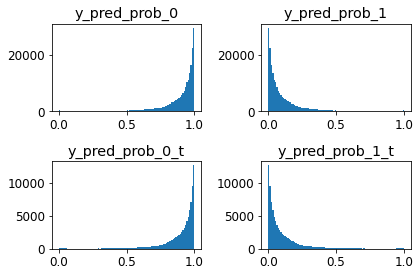

In [16]:
show_predict_proba(bag, model=bag.model, data=bag.data, data_t=bag.data_t)

In [17]:
def show_thresholding(bag, model=None, data=None, expected=None):
    """
    # show_thresholding
    """
    predict_proba = model.predict_proba(data)
    for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
        predicted_tmp = binarize(predict_proba, threshold=threshold)[:,1]
        confusion_tmp = metrics.confusion_matrix(expected, predicted_tmp)
        recall_tmp    = metrics.recall_score(expected, predicted_tmp)
        precision_tmp  = metrics.precision_score(expected, predicted_tmp)
        print("\nconfusion_%.1f\n" % threshold, confusion_tmp)
        print("recall=%.3f, precision=%.3f" % (recall_tmp, precision_tmp))

In [18]:
show_thresholding(bag, model=bag.model, data=bag.data_t, expected=bag.target_t)


confusion_0.3
 [[77943  7351]
 [   13   134]]
recall=0.912, precision=0.018

confusion_0.4
 [[81021  4273]
 [   18   129]]
recall=0.878, precision=0.029

confusion_0.5
 [[82623  2671]
 [   18   129]]
recall=0.878, precision=0.046

confusion_0.6
 [[83600  1694]
 [   18   129]]
recall=0.878, precision=0.071

confusion_0.7
 [[84183  1111]
 [   20   127]]
recall=0.864, precision=0.103


<pre>Confusion matrix:
    True  Negative    False Positive
    False Negative     True Positive</pre>

In [19]:
def show_roc_curve(bag, target=None, predict_proba=None):
    """
    # ROC curve = (Receiver Operating Characteristic curve)
    # was first developed during World War II for detecting enemy objects in battlefields.
    # plotting True Positive Rate (TPR) vs False Positive Rate (FPR) at various thresholds.
    # TPR a.k.a. sensitivity, recall, or probability of detection.
    # FPR a.k.a fall-out or probability of false alarm = (1-specificity).
    # So ROC curve is the sensitivity as a function of fall-out.
    """
    fpr, tpr, thresholds = metrics.roc_curve(target, predict_proba[:,1])
    plt.plot(fpr, tpr, linewidth=3.0, color='red')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)

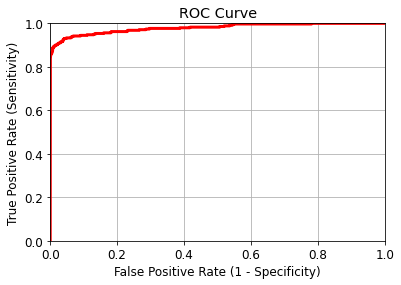

In [20]:
predict_proba = bag.model.predict_proba(bag.data)
# predict_proba
show_roc_curve(bag, target=bag.target, predict_proba=predict_proba)

In [21]:
#Now add AUC (Area Under Curve) under the curve
fpr, tpr, thresholds = metrics.roc_curve(bag.target, predict_proba[:,1])
print("AUC = %.4f" % float(metrics.auc(fpr, tpr)))

AUC = 0.9789
